In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

import statsmodels.api as sm

from utils import *

In [3]:
flu = pd.read_csv("fludata.txt", sep=" ")

In [4]:
X = flu.drop(columns=["assign", "outcome"])
X = sm.add_constant(X)
y = flu[["outcome"]]

In [5]:
assign_logit = sm.Logit(y, X).fit(disp=0)

In [6]:
print(assign_logit.summary())

                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 2861
Model:                          Logit   Df Residuals:                     2851
Method:                           MLE   Df Model:                            9
Date:                Fri, 10 May 2024   Pseudo R-squ.:                 0.04047
Time:                        14:26:23   Log-Likelihood:                -800.21
converged:                       True   LL-Null:                       -833.96
Covariance Type:            nonrobust   LLR p-value:                 4.713e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2822      0.405     -5.635      0.000      -3.076      -1.488
receive       -0.0510      0.158     -0.323      0.747      -0.361       0.259
age           -0.0079      0.006     -1.419      0.1

# Logitsic regression

In [7]:
%%time
def logistic_approx(X, y):
    X, y = np.array(X), np.array(y).reshape((-1, 1))
    n, p = X.shape
    beta = LogisticRegression(max_iter=1000).fit(X, y.ravel()).coef_.reshape((-1, 1))
    ps = np.sqrt(sigmoid(X @ beta))
    W_sqrt = np.diag(ps.flatten())
    Z = W_sqrt @ X 
    H = Z @ (Z.T @ Z) @ Z.T
    eps = W_sqrt @ (y - ps.reshape((-1, 1)))

    beta_approx, err = [], []
    for i in range(n):
        X_i, y_i = X[np.arange(X.shape[0]) != i], y[np.arange(y.shape[0]) != i]
        beta_i_loo = linear_loo(Z, eps, i, H, beta.reshape((-1, 1)))
        p_i = sigmoid(X_i @ beta_i_loo)
        err.append(log_loss(y_i, p_i))
        beta_approx.append(beta_i_loo)
    return beta_approx, err

beta_approx, approx_err = logistic_approx(X, y)

CPU times: user 30.8 s, sys: 2.94 s, total: 33.8 s
Wall time: 4.97 s


In [8]:
%%time 
def logistic_loocv(X, y):
    X, y = np.array(X), np.array(y).reshape((-1, 1))
    n = X.shape[0]
    beta_loocv, err = [], []
    for i in range(n):
        X_i, y_i = X[np.arange(X.shape[0]) != i], y[np.arange(y.shape[0]) != i]
        beta_i = LogisticRegression(max_iter=1000).fit(X_i, y_i.ravel()).coef_.reshape((-1, 1))
        p_i = sigmoid(X_i @ beta_i)
        err.append(log_loss(y_i, p_i))
        beta_loocv.append(beta_i)
    return beta_loocv, err

beta_loocv, loocv_err = logistic_loocv(X, y)

CPU times: user 15min 48s, sys: 31.1 s, total: 16min 19s
Wall time: 2min 20s


In [9]:
beta_err = [np.linalg.norm(beta_approx[i] - beta_loocv[i]) for i in range(len(beta_approx))]

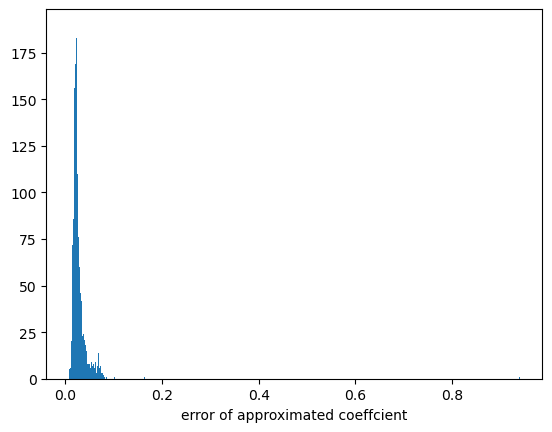

In [33]:
plt.hist(beta_err, bins=1000)
plt.xlabel("error of approximated coeffcient")
plt.show()

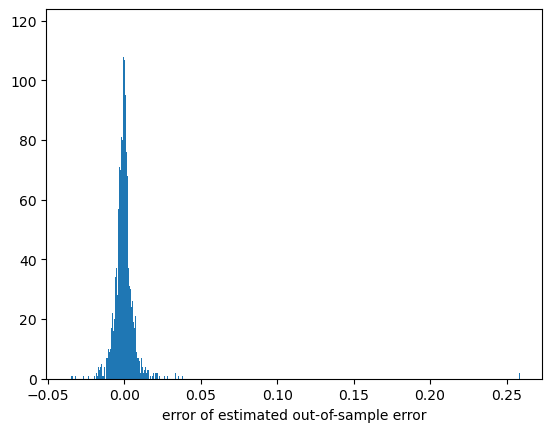

In [32]:
plt.hist(np.array(approx_err) - np.array(loocv_err), bins=1000)
plt.xlabel("error of estimated out-of-sample error")
plt.show()

In [13]:
np.abs(np.mean(approx_err) - np.mean(loocv_err))

0.000316134717254557

# Logistic Ridge

In [14]:
def logistic_ridge_approx(X, y, alpha):
    X, y = np.array(X), np.array(y).reshape((-1, 1))
    n, p = X.shape
    beta = LogisticRegression(penalty="l2", C=1/alpha, fit_intercept=False, max_iter=1000).fit(X, y.ravel()).coef_.reshape((-1, 1))
    ps = np.sqrt(sigmoid(X @ beta))
    W_sqrt = np.diag(ps.flatten())
    Z = W_sqrt @ X 
    H = Z @ (Z.T @ Z + 2 * alpha * np.identity(p)) @ Z.T
    eps = W_sqrt @ (y - ps.reshape((-1, 1)))

    beta_approx, err = [], []
    for i in range(n):
        X_i, y_i = X[np.arange(X.shape[0]) != i], y[np.arange(y.shape[0]) != i]
        beta_i_loo = ridge_loo(Z, eps, i, H, beta.reshape((-1, 1)), 2*alpha)
        p_i = sigmoid(X_i @ beta_i_loo)
        err.append(log_loss(y_i, p_i))
        beta_approx.append(beta_i_loo)
    return beta_approx, err

def logistic_ridge_loocv(X, y, alpha):
    X, y = np.array(X), np.array(y).reshape((-1, 1))
    n, p = X.shape

    beta_loocv, err = [], []
    for i in range(n):
        X_i, y_i = X[np.arange(X.shape[0]) != i], y[np.arange(y.shape[0]) != i]
        beta_i = LogisticRegression(penalty="l2", C=1/alpha, fit_intercept=False, max_iter=1000).fit(X_i, y_i.ravel()).coef_.reshape((-1, 1))
        p_i = sigmoid(X_i @ beta_i)
        err.append(log_loss(y_i, p_i))
        beta_loocv.append(beta_i)
    return beta_loocv, err


In [20]:
beta_diff, err_diff = [], []
err_ridge, err_ridge_loocv = [], []
time_ridge, time_ridge_loocv = [], []
for alpha in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    time1 = time.time()
    beta_approx, err_approx = logistic_ridge_approx(X, y, alpha)
    time_ridge.append(time.time() - time1)

    time2 = time.time()
    beta_loocv, err_loocv = logistic_ridge_loocv(X, y, alpha)
    time_ridge_loocv.append(time.time() - time2)

    err_ridge.append(np.sum(err_approx))
    err_ridge_loocv.append(np.sum(err_loocv))
    
    beta_diff.append(np.sum( [np.linalg.norm(beta_approx[i] - beta_loocv[i]) for i in range(len(beta_approx))] ))
    err_diff.append(np.mean(err_approx) - np.mean(err_loocv))
    

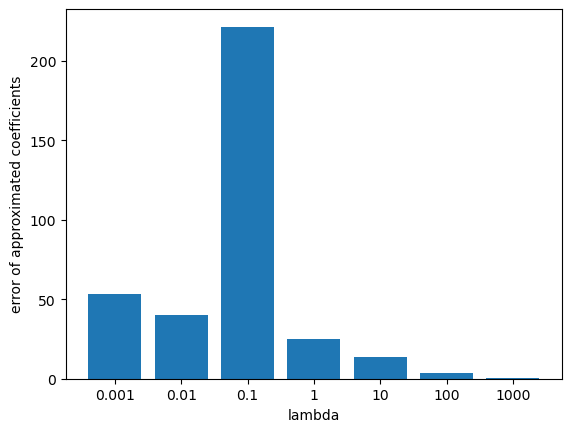

In [51]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
plt.bar(np.arange(7), beta_diff)
plt.xlabel("lambda")
plt.xticks(np.arange(7), alphas)
plt.ylabel("error of approximated coefficients")
plt.show()


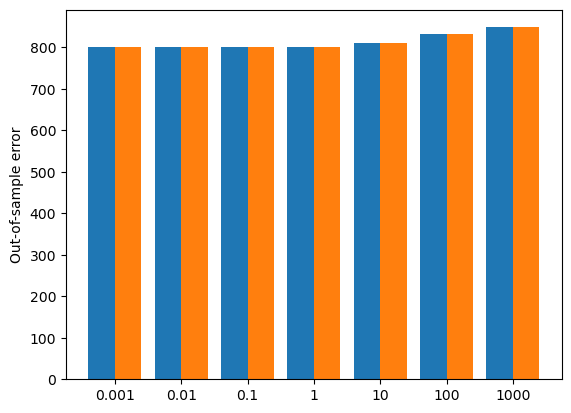

In [54]:
plt.bar(np.arange(7)-0.2, err_ridge, 0.4, label="loo formula")
plt.bar(np.arange(7)+0.2, err_ridge_loocv, 0.4, label="repeat-fitting")
plt.xticks(np.arange(7), alphas)
plt.ylabel("Out-of-sample error")
plt.show()

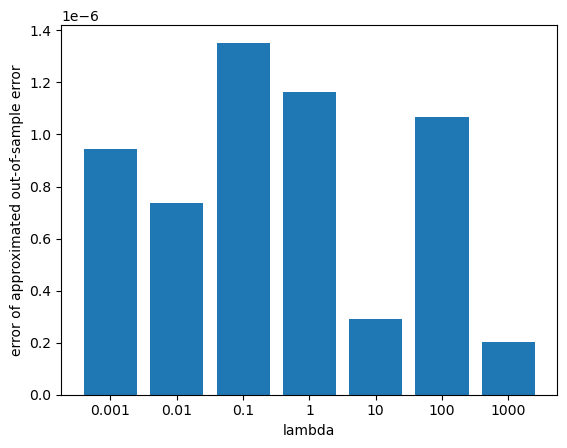

In [53]:
plt.bar(np.arange(7), np.abs(err_diff))
plt.xticks(np.arange(7), alphas)
plt.ylabel("error of approximated out-of-sample error")
plt.xlabel("lambda")
plt.show()